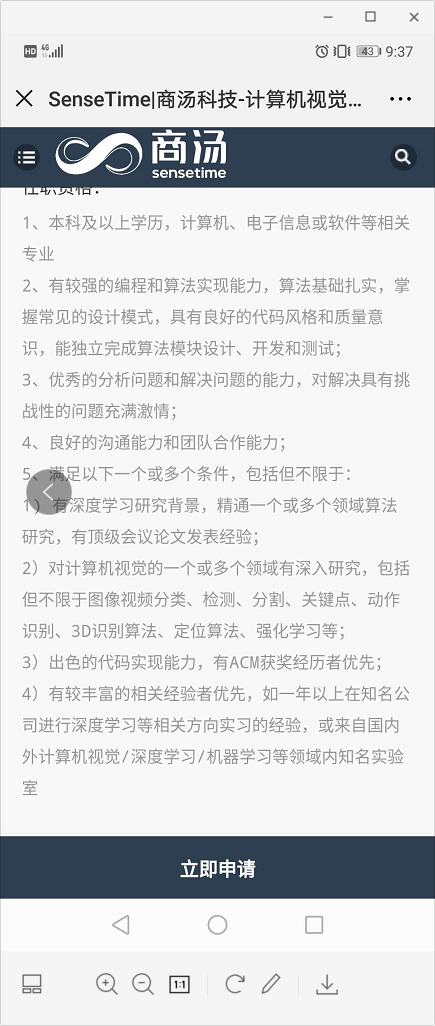

#### 简历上吹的牛逼汇总  

#### 一、项目
1. 发表的论文要能给个说法  
2. 地平线实习项目  
    - ldmk
        - 应用场景（Motivation）
        - 数据集与训练
        - 结果（客观评价标准）
    - DMS手部检测器
        - 简介
            - DMS应用场景
                - 抽烟、打电话
                - 人脸朝向、打哈欠、闭眼
                - 手部动作（静态和动态）
                - 多模交互
            - ADAS场景
                - 前车测距
                - 车道线检测
                - 交通标示牌分割与识别
    - 表情识别预研
3. 大件行李检测  
    - 标注数据 难点：要不要在训练集加入难例？ Trick：应该在训练集加入一些负样例，而不是只靠YOLO中的负样例。
    
    - 训练：YOLOv3
    - 策略：检测器加追踪器
    - 评价：速度，Precision， Recall
    - 封装：Pyinstaller
4. 钢筋数量识别
    - 任务简介
    - 模型与数据增强
    - 评价指标
    
二、理论知识储备

1. 图像基础知识，如滤波，色彩空间，直方图，边缘, 图像配准等，结合OpenCV
2. 深度学习基本概念：BN，Dropout，过拟合，交叉验证等
3. **常用分类网络及其变体。记一些小trick，如ResNet-D；NiN; MobileNet的深度宽度选择等**  
4. 基本概念如F1 score, mAP, FLOPs，ROC，AUC等  
5. **梯度下降与反向传播公式及推导**  
6. 机器学习算法如**SVM**，**决策树**和随机森林；AdaBoost等集成方法；
7. **目标检测算法YOLO和Faster-RCNN系列需要透彻理解**
8. 关键点检测需要能说出自己的理解和训练中的细节
可能需要：了解下语义分割的相关知识

三、工程：

1. Python进阶知识点：**kwags, import搜索过程、修饰器、生成器与Yield
2. Gluon与Keras

四、一些其他问题：
1. 项目中遇到哪些困难，是如何解决的？哪些没有解决？


## MiniGoogLeNet

#### Module Defination

In [84]:
from mxnet.gluon import nn, data as gdata
from mxnet import gluon, nd, autograd, init
from mxnet.gluon.data.vision.datasets import CIFAR10
from mxnet.gluon.utils import split_and_load
from mxnet.gluon.data.vision import transforms
from sklearn.metrics import classfication_report
import mxnet as mx
import time


* ConvModule

In [53]:
def ConvSame(channel, k, s, activation=None):
    """'same' mode convolution for stride=1"""
    return nn.Conv2D(channel, k, (1,1), int((k-1)/2), activation=activation)

class ConvModule(nn.HybridBlock):
    def __init__(self, channel, k, s, padding='same', **kwags):
        super(ConvModule, self).__init__(**kwags)
        if padding=='same':
            self.conv = ConvSame(channel, k, s)
        else:
            self.conv = nn.Conv2D(channel, k, s, padding)
        self.batchnorm = nn.BatchNorm()
        self.relu = nn.Activation('relu')
        
    def hybrid_forward(self, F, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        return self.relu(x)

In [54]:
convmodule = ConvModule(96, 3, 1)
convmodule

ConvModule(
  (relu): Activation(relu)
  (batchnorm): BatchNorm(axis=1, use_global_stats=False, momentum=0.9, eps=1e-05, fix_gamma=False, in_channels=None)
  (conv): Conv2D(None -> 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

* Miniception

In [60]:
class Miniception(nn.HybridBlock):
    def __init__(self, ch1, ch3, **kwags):
        super(Miniception, self).__init__(**kwags)
        self.conv1x1 = ConvModule(ch1, 1, 1)
        self.conv3x3 = ConvModule(ch3, 3, 1)
    
    def hybrid_forward(self, F, x):
        #这样也可以，但是相当于在模型中使用了固定的NDArray接口，故无法使用net.hybridize()
        #return nd.concat(self.conv1x1(x), self.conv3x3(x))  
        return F.concat(self.conv1x1(x), self.conv3x3(x))

In [61]:
net = Miniception(32, 32)
net

Miniception(
  (conv3x3): ConvModule(
    (relu): Activation(relu)
    (batchnorm): BatchNorm(axis=1, use_global_stats=False, momentum=0.9, eps=1e-05, fix_gamma=False, in_channels=None)
    (conv): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv1x1): ConvModule(
    (relu): Activation(relu)
    (batchnorm): BatchNorm(axis=1, use_global_stats=False, momentum=0.9, eps=1e-05, fix_gamma=False, in_channels=None)
    (conv): Conv2D(None -> 32, kernel_size=(1, 1), stride=(1, 1))
  )
)

* Downsample Module

In [69]:
class DownsampleModule(nn.HybridBlock):
    def __init__(self, ch3, **kwags):
        super(DownsampleModule, self).__init__(**kwags)
        self.conv3x3 = ConvModule(ch3, k=3, s=2, padding=(0,0))  # 'valid' conv
        self.maxpool = nn.MaxPool2D((3,3),2)
    def hybrid_forward(self, F, x):
        #return nd.concat(self.conv3x3(x), self.maxpool(x))
        return F.concat(self.conv3x3(x), self.maxpool(x))

#### Model Defination

In [70]:
def MiniGoogLeNet(num_classes):
    net = nn.HybridSequential()
    net.add(
        ConvModule(96, 3, 1),
        Miniception(32, 32),
        Miniception(32, 48),
        DownsampleModule(80),
        
        Miniception(112, 48),
        Miniception(96, 64),
        Miniception(80, 80),
        Miniception(48, 96),
        DownsampleModule(96),
        
        Miniception(176, 160),
        Miniception(176, 160),
        
        nn.GlobalAvgPool2D(),
        nn.Dropout(0.5),
        nn.Dense(num_classes)   
    )
    return net

In [71]:
net = MiniGoogLeNet(10)
ctx=[mx.gpu(0), mx.gpu(1)]
net.initialize(init=init.Xavier(), ctx=ctx)
x_test = nd.random_normal(shape=(2,3,32,32))
x_test_gpus = split_and_load(x_test, ctx)
net.summary(x_test_gpus[0])

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 3, 32, 32)               0
            Conv2D-1                             (1, 96, 32, 32)            2688
         BatchNorm-2                             (1, 96, 32, 32)             384
        Activation-3                             (1, 96, 32, 32)               0
        ConvModule-4                             (1, 96, 32, 32)               0
            Conv2D-5                             (1, 32, 32, 32)            3104
         BatchNorm-6                             (1, 32, 32, 32)             128
        Activation-7                             (1, 32, 32, 32)               0
        ConvModule-8                             (1, 32, 32, 32)               0
            Conv2D-9                             (1, 32, 32, 32)           27680
        BatchNorm-10        

#### Dataset loading

In [65]:
def naive_transform(data, label):
    data = data.transpose((2,0,1))  # 原始尺寸：data.shape = (32, 32, 3)
    return data.astype('float32')/255., label.astype('float32')
#dataset_train = CIFAR10()
#dataset_test = CIFAR10(train=False)
train_iter = gdata.DataLoader(CIFAR10(transform=naive_transform),
                        batch_size=128, shuffle=True, last_batch='rollover')
test_iter = gdata.DataLoader(CIFAR10(train=False, transform=naive_transform),
                        batch_size=128, shuffle=True, last_batch='rollover')

In [66]:
len(train_iter), len(test_iter)

(390, 78)

In [67]:
def evaluate(test_iter):
    metric_val = mx.metric.Accuracy()
    val_loss = 0
    for X, y in test_iter:
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        outputs = [net(x) for x in X]
        loss = [criterion(output, target) for output, target in zip(outputs, y)]
        val_loss += sum([l.mean().asscalar() for l in loss])/len(ctx)
        metric_val.update(y, outputs)
    return metric_val.get()[1], val_loss/len(test_iter)

In [13]:
EPOCHS = 50
BATCH_SIZE = 128
metric = mx.metric.Accuracy()
ctx = [mx.gpu(0), mx.gpu(1)]
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-1, 'momentum':0.9})
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

for epoch in range(EPOCHS):
    tic = time.time()
    metric.reset()
    train_loss_avg = 0
    for it, (X, y) in enumerate(train_iter):
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        with autograd.record():
            logits = [net(x) for x in X]
            loss = [criterion(logit, label) for logit,label in zip(logits, y)]
        for l in loss:
            l.backward() 
        # 每个iteration将当期batch的平均loss加入loss_history
        train_loss_avg += sum([l.mean().asscalar() for l in loss])/2
        trainer.step(BATCH_SIZE)
        metric.update(y, logits)
        #if it%100 == 0:
        #    name, accuracy = metric.get()
        #    print("Epoch {}, Iteration {}: accuracy: {:.4f}, loss: {:.4f}".format(epoch, it, 
        #                                                                          accuracy, train_loss_avg/(it+1)))
    name, accuracy = metric.get()
    val_acc, val_loss = evaluate(test_iter)
    print("Epoch {}, train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f} epoch time: {:.4f}".format(
           epoch, accuracy, train_loss_avg/len(train_iter), val_acc, val_loss, time.time()-tic))

Epoch 0, train_acc: 0.4893, train_loss: 1.4108, val_acc: 0.4945, val_loss: 1.3799 epoch time: 29.9281
Epoch 1, train_acc: 0.6820, train_loss: 0.9027, val_acc: 0.6822, val_loss: 0.9154 epoch time: 28.6703
Epoch 2, train_acc: 0.7614, train_loss: 0.6880, val_acc: 0.7580, val_loss: 0.7364 epoch time: 29.1023
Epoch 3, train_acc: 0.8053, train_loss: 0.5683, val_acc: 0.8068, val_loss: 0.5427 epoch time: 28.9701
Epoch 4, train_acc: 0.8354, train_loss: 0.4826, val_acc: 0.8278, val_loss: 0.6234 epoch time: 28.6498
Epoch 5, train_acc: 0.8593, train_loss: 0.4108, val_acc: 0.8498, val_loss: 0.5850 epoch time: 28.3676
Epoch 6, train_acc: 0.8784, train_loss: 0.3527, val_acc: 0.8686, val_loss: 0.5522 epoch time: 28.7278
Epoch 7, train_acc: 0.8954, train_loss: 0.3036, val_acc: 0.8843, val_loss: 0.5450 epoch time: 29.0189
Epoch 8, train_acc: 0.9144, train_loss: 0.2517, val_acc: 0.8989, val_loss: 0.5705 epoch time: 28.8462
Epoch 9, train_acc: 0.9236, train_loss: 0.2224, val_acc: 0.9081, val_loss: 0.5703 

* 把上面输出复制到一个文件中：train_1.log

In [19]:
!cat train_1.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_1.csv

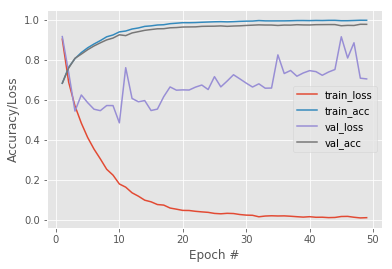

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_train_log(logpath, viz=True):
    df = pd.read_csv(logpath, delimiter='\t', index_col=False)
    plt.style.use('ggplot')
    df.columns = ["epoch", "train_acc","train_loss","val_acc","val_loss"]
    plt.plot(df['epoch'], df['train_loss'], label="train_loss")
    plt.plot(df['epoch'], df['train_acc'], label="train_acc")
    plt.plot(df['epoch'], df['val_loss'], label="val_loss")
    plt.plot(df['epoch'], df['val_acc'], label="val_acc")

    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy/Loss")
    plt.legend()
    if viz: 
        plt.show() 
    else: 
        plt.savefig('loss_curve.png')
    
plot_train_log('train_1.csv')

In [73]:
EPOCHS = 50
BATCH_SIZE = 128
metric = mx.metric.Accuracy()
ctx = [mx.gpu(0), mx.gpu(1)]

net = MiniGoogLeNet(10)
net.initialize(init=init.Xavier(), ctx=ctx)
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-2, 'momentum':0.9})
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

for epoch in range(EPOCHS):
    tic = time.time()
    metric.reset()
    train_loss_avg = 0
    for it, (X, y) in enumerate(train_iter):
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        with autograd.record():
            logits = [net(x) for x in X]
            loss = [criterion(logit, label) for logit,label in zip(logits, y)]
        for l in loss:
            l.backward() 
        # 每个iteration将当期batch的平均loss加入loss_history
        train_loss_avg += sum([l.mean().asscalar() for l in loss])/2
        trainer.step(BATCH_SIZE)
        metric.update(y, logits)
        #if it%100 == 0:
        #    name, accuracy = metric.get()
        #    print("Epoch {}, Iteration {}: accuracy: {:.4f}, loss: {:.4f}".format(epoch, it, 
        #                                                                          accuracy, train_loss_avg/(it+1)))
    trainer.set_learning_rate(trainer.learning_rate * 0.95)
    name, accuracy = metric.get()
    val_acc, val_loss = evaluate(test_iter)
    print("Epoch {}, train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f} epoch time: {:.4f}".format(
           epoch, accuracy, train_loss_avg/len(train_iter), val_acc, val_loss, time.time()-tic))

Epoch 0, train_acc: 0.4777, train_loss: 1.4200, val_acc: 0.4939, val_loss: 1.2071 epoch time: 26.8202
Epoch 1, train_acc: 0.6553, train_loss: 0.9731, val_acc: 0.6594, val_loss: 0.8808 epoch time: 26.8500
Epoch 2, train_acc: 0.7203, train_loss: 0.7932, val_acc: 0.7013, val_loss: 1.1546 epoch time: 26.6705
Epoch 3, train_acc: 0.7658, train_loss: 0.6700, val_acc: 0.7654, val_loss: 0.6845 epoch time: 26.8058
Epoch 4, train_acc: 0.8011, train_loss: 0.5747, val_acc: 0.7815, val_loss: 0.9064 epoch time: 26.9243
Epoch 5, train_acc: 0.8315, train_loss: 0.4890, val_acc: 0.8143, val_loss: 0.7947 epoch time: 26.9346
Epoch 6, train_acc: 0.8534, train_loss: 0.4232, val_acc: 0.8448, val_loss: 0.5901 epoch time: 26.8076
Epoch 7, train_acc: 0.8744, train_loss: 0.3666, val_acc: 0.8602, val_loss: 0.6208 epoch time: 26.7994
Epoch 8, train_acc: 0.8967, train_loss: 0.3031, val_acc: 0.8741, val_loss: 0.7529 epoch time: 26.7509
Epoch 9, train_acc: 0.9142, train_loss: 0.2517, val_acc: 0.8889, val_loss: 0.7859 

In [74]:
!cat train_2.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_2.csv

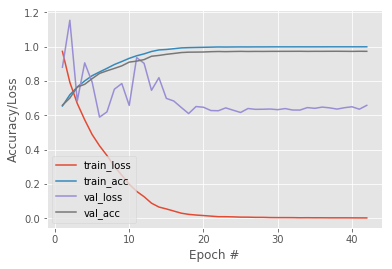

In [75]:
plot_train_log('train_2.csv')

In [81]:
EPOCHS = 50
BATCH_SIZE = 128
metric = mx.metric.Accuracy()
ctx = [mx.gpu(0), mx.gpu(1)]

net = MiniGoogLeNet(10)
net.initialize(init=init.Xavier(), ctx=ctx)
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-3, 'momentum':0.9})
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

for epoch in range(1,100):
    tic = time.time()
    metric.reset()
    train_loss_avg = 0
    for it, (X, y) in enumerate(train_iter):
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        with autograd.record():
            logits = [net(x) for x in X]
            loss = [criterion(logit, label) for logit,label in zip(logits, y)]
        for l in loss:
            l.backward() 
        # 每个iteration将当期batch的平均loss加入loss_history
        train_loss_avg += sum([l.mean().asscalar() for l in loss])/2
        trainer.step(BATCH_SIZE)
        metric.update(y, logits)
        #if it%100 == 0:
        #    name, accuracy = metric.get()
        #    print("Epoch {}, Iteration {}: accuracy: {:.4f}, loss: {:.4f}".format(epoch, it, 
        #                                                                          accuracy, train_loss_avg/(it+1)))
    trainer.set_learning_rate(trainer.learning_rate * 0.95)
    name, accuracy = metric.get()
    val_acc, val_loss = evaluate(test_iter)
    print("Epoch {}, train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f} epoch time: {:.4f}".format(
           epoch, accuracy, train_loss_avg/len(train_iter), val_acc, val_loss, time.time()-tic))

Epoch 1, train_acc: 0.3279, train_loss: 1.8022, val_acc: 0.3534, val_loss: 1.4412 epoch time: 25.7553
Epoch 2, train_acc: 0.4822, train_loss: 1.4203, val_acc: 0.4839, val_loss: 1.3592 epoch time: 26.5493
Epoch 3, train_acc: 0.5493, train_loss: 1.2455, val_acc: 0.5526, val_loss: 1.2236 epoch time: 26.4866
Epoch 4, train_acc: 0.5935, train_loss: 1.1336, val_acc: 0.6001, val_loss: 1.0358 epoch time: 26.5553
Epoch 5, train_acc: 0.6253, train_loss: 1.0527, val_acc: 0.6236, val_loss: 1.1009 epoch time: 26.6941
Epoch 6, train_acc: 0.6486, train_loss: 0.9855, val_acc: 0.6428, val_loss: 1.0908 epoch time: 26.5306
Epoch 7, train_acc: 0.6715, train_loss: 0.9299, val_acc: 0.6681, val_loss: 0.9690 epoch time: 26.4868
Epoch 8, train_acc: 0.6868, train_loss: 0.8873, val_acc: 0.6802, val_loss: 1.0123 epoch time: 26.6150
Epoch 9, train_acc: 0.7000, train_loss: 0.8383, val_acc: 0.6989, val_loss: 0.8885 epoch time: 26.3618
Epoch 10, train_acc: 0.7169, train_loss: 0.8060, val_acc: 0.7108, val_loss: 0.8845

Epoch 81, train_acc: 0.9437, train_loss: 0.2010, val_acc: 0.9170, val_loss: 0.6638 epoch time: 26.8433
Epoch 82, train_acc: 0.9443, train_loss: 0.2005, val_acc: 0.9169, val_loss: 0.6571 epoch time: 27.1756
Epoch 83, train_acc: 0.9433, train_loss: 0.1999, val_acc: 0.9160, val_loss: 0.6769 epoch time: 26.6311
Epoch 84, train_acc: 0.9419, train_loss: 0.2037, val_acc: 0.9155, val_loss: 0.6614 epoch time: 26.8039
Epoch 85, train_acc: 0.9442, train_loss: 0.2017, val_acc: 0.9170, val_loss: 0.6688 epoch time: 26.7208
Epoch 86, train_acc: 0.9440, train_loss: 0.1980, val_acc: 0.9172, val_loss: 0.6629 epoch time: 26.7929
Epoch 87, train_acc: 0.9437, train_loss: 0.1990, val_acc: 0.9170, val_loss: 0.6655 epoch time: 26.7477
Epoch 88, train_acc: 0.9462, train_loss: 0.1966, val_acc: 0.9190, val_loss: 0.6647 epoch time: 26.7299
Epoch 89, train_acc: 0.9452, train_loss: 0.1956, val_acc: 0.9176, val_loss: 0.6706 epoch time: 26.5582
Epoch 90, train_acc: 0.9454, train_loss: 0.1959, val_acc: 0.9183, val_los

In [82]:
!cat train_3.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_3.csv

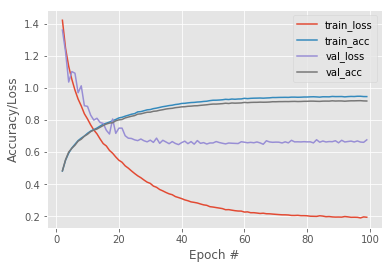

In [83]:
plot_train_log('train_3.csv')

#### 加上数据增强

In [86]:
dataset_train = CIFAR10()
dataset_test = CIFAR10(train=False)
trans_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(32,32)),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=0.1, contrast=0.1, 
                                 saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2023, 0.1994, 0.2010]),
])
trans_test = transforms.Compose([
    transforms.ToTensor()
])
train_iter = gdata.DataLoader(dataset_train.transform_first(trans_train),
                        batch_size=128, shuffle=True, last_batch='rollover', num_workers=-1)
test_iter = gdata.DataLoader(dataset_test.transform_first(trans_test),
                        batch_size=128, shuffle=True, last_batch='rollover', num_workers=-1)

In [88]:
EPOCHS = 50
BATCH_SIZE = 128
metric = mx.metric.Accuracy()
ctx = [mx.gpu(0), mx.gpu(1)]

net = MiniGoogLeNet(10)
net.initialize(init=init.Xavier(), ctx=ctx)
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-2, 'momentum':0.9})
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

for epoch in range(1,100):
    tic = time.time()
    metric.reset()
    train_loss_avg = 0
    for it, (X, y) in enumerate(train_iter):
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        with autograd.record():
            logits = [net(x) for x in X]
            loss = [criterion(logit, label) for logit,label in zip(logits, y)]
        for l in loss:
            l.backward() 
        # 每个iteration将当期batch的平均loss加入loss_history
        train_loss_avg += sum([l.mean().asscalar() for l in loss])/2
        trainer.step(BATCH_SIZE)
        metric.update(y, logits)
        
    trainer.set_learning_rate(trainer.learning_rate * 0.95)
    name, accuracy = metric.get()
    val_acc, val_loss = evaluate(test_iter)
    print("Epoch {}, train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f}, epoch time: {:.4f}".format(
           epoch, accuracy, train_loss_avg/len(train_iter), val_acc, val_loss, time.time()-tic))

Epoch 1, train_acc: 0.3235, train_loss: 1.8517, val_acc: 0.2930, val_loss: 2.3510, epoch time: 29.8890
Epoch 2, train_acc: 0.4396, train_loss: 1.5524, val_acc: 0.3995, val_loss: 2.2813, epoch time: 29.9774
Epoch 3, train_acc: 0.4988, train_loss: 1.3957, val_acc: 0.4477, val_loss: 2.5459, epoch time: 29.9478
Epoch 4, train_acc: 0.5363, train_loss: 1.3085, val_acc: 0.4785, val_loss: 2.6367, epoch time: 29.9617
Epoch 5, train_acc: 0.5636, train_loss: 1.2396, val_acc: 0.5138, val_loss: 2.0072, epoch time: 29.9884
Epoch 6, train_acc: 0.5846, train_loss: 1.1744, val_acc: 0.5322, val_loss: 2.1792, epoch time: 29.9440
Epoch 7, train_acc: 0.6010, train_loss: 1.1382, val_acc: 0.5509, val_loss: 2.1476, epoch time: 29.9808
Epoch 8, train_acc: 0.6159, train_loss: 1.0974, val_acc: 0.5670, val_loss: 2.2768, epoch time: 29.9944
Epoch 9, train_acc: 0.6269, train_loss: 1.0630, val_acc: 0.5716, val_loss: 2.1679, epoch time: 29.9890
Epoch 10, train_acc: 0.6435, train_loss: 1.0291, val_acc: 0.5881, val_los

Epoch 80, train_acc: 0.7791, train_loss: 0.6411, val_acc: 0.7349, val_loss: 1.4420, epoch time: 30.3884
Epoch 81, train_acc: 0.7791, train_loss: 0.6417, val_acc: 0.7353, val_loss: 1.4421, epoch time: 30.0296
Epoch 82, train_acc: 0.7801, train_loss: 0.6419, val_acc: 0.7389, val_loss: 1.3986, epoch time: 30.1797
Epoch 83, train_acc: 0.7796, train_loss: 0.6376, val_acc: 0.7384, val_loss: 1.3948, epoch time: 30.1350
Epoch 84, train_acc: 0.7822, train_loss: 0.6348, val_acc: 0.7373, val_loss: 1.4410, epoch time: 30.0828
Epoch 85, train_acc: 0.7829, train_loss: 0.6319, val_acc: 0.7399, val_loss: 1.4265, epoch time: 30.1202
Epoch 86, train_acc: 0.7809, train_loss: 0.6324, val_acc: 0.7381, val_loss: 1.4102, epoch time: 30.1568
Epoch 87, train_acc: 0.7796, train_loss: 0.6373, val_acc: 0.7347, val_loss: 1.4482, epoch time: 30.0652


KeyboardInterrupt: 

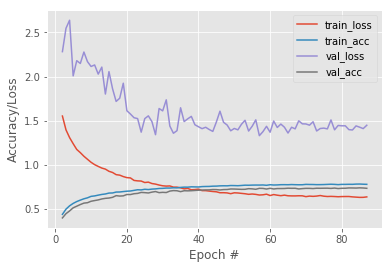

In [89]:
!cat train_4.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_4.csv
plot_train_log('train_4.csv')

In [98]:
dataset_train = CIFAR10()
dataset_test = CIFAR10(train=False)
trans_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(32,32)),
    transforms.RandomFlipLeftRight(),
    #transforms.RandomColorJitter(brightness=0.1, contrast=0.1, 
    #                             saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2023, 0.1994, 0.2010]),
])
trans_test = transforms.Compose([
    transforms.ToTensor()
])
train_iter = gdata.DataLoader(dataset_train.transform_first(trans_train),
                        batch_size=128, shuffle=True, last_batch='rollover', num_workers=-1)
test_iter = gdata.DataLoader(dataset_test.transform_first(trans_test),
                        batch_size=128, shuffle=True, last_batch='rollover', num_workers=-1)

In [101]:
EPOCHS = 50
BATCH_SIZE = 128
metric = mx.metric.Accuracy()
ctx = [mx.gpu(0), mx.gpu(1)]

net = MiniGoogLeNet(10)
net.initialize(init=init.Xavier(), ctx=ctx)
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-2, 'momentum':0.9})
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

for epoch in range(1,100):
    tic = time.time()
    metric.reset()
    train_loss_avg = 0
    for it, (X, y) in enumerate(train_iter):
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        with autograd.record():
            logits = [net(x) for x in X]
            loss = [criterion(logit, label) for logit,label in zip(logits, y)]
        for l in loss:
            l.backward() 
        # 每个iteration将当期batch的平均loss加入loss_history
        train_loss_avg += sum([l.mean().asscalar() for l in loss])/2
        trainer.step(BATCH_SIZE)
        metric.update(y, logits)
        
    #trainer.set_learning_rate(trainer.learning_rate * 0.95)
    name, accuracy = metric.get()
    val_acc, val_loss = evaluate(test_iter)
    print("Epoch {}, train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f}, epoch time: {:.4f}".format(
           epoch, accuracy, train_loss_avg/len(train_iter), val_acc, val_loss, time.time()-tic))

Epoch 1, train_acc: 0.3353, train_loss: 1.8103, val_acc: 0.3057, val_loss: 2.3929, epoch time: 29.2148
Epoch 2, train_acc: 0.4556, train_loss: 1.5096, val_acc: 0.4150, val_loss: 2.4972, epoch time: 29.4377
Epoch 3, train_acc: 0.5090, train_loss: 1.3657, val_acc: 0.4671, val_loss: 2.3964, epoch time: 29.5674
Epoch 4, train_acc: 0.5498, train_loss: 1.2654, val_acc: 0.5012, val_loss: 2.2586, epoch time: 29.2394
Epoch 5, train_acc: 0.5793, train_loss: 1.1922, val_acc: 0.5329, val_loss: 2.1367, epoch time: 29.4741
Epoch 6, train_acc: 0.6025, train_loss: 1.1253, val_acc: 0.5542, val_loss: 1.9351, epoch time: 29.4311
Epoch 7, train_acc: 0.6165, train_loss: 1.0867, val_acc: 0.5620, val_loss: 1.9938, epoch time: 29.4539
Epoch 8, train_acc: 0.6303, train_loss: 1.0470, val_acc: 0.5716, val_loss: 2.1244, epoch time: 29.5334
Epoch 9, train_acc: 0.6479, train_loss: 1.0035, val_acc: 0.5968, val_loss: 1.8661, epoch time: 29.3309
Epoch 10, train_acc: 0.6569, train_loss: 0.9876, val_acc: 0.5877, val_los

KeyboardInterrupt: 

In [102]:
trainer.set_learning_rate(trainer.learning_rate * 0.1)
for epoch in range(60,100):
    tic = time.time()
    metric.reset()
    train_loss_avg = 0
    for it, (X, y) in enumerate(train_iter):
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        with autograd.record():
            logits = [net(x) for x in X]
            loss = [criterion(logit, label) for logit,label in zip(logits, y)]
        for l in loss:
            l.backward() 
        # 每个iteration将当期batch的平均loss加入loss_history
        train_loss_avg += sum([l.mean().asscalar() for l in loss])/2
        trainer.step(BATCH_SIZE)
        metric.update(y, logits)
        
    #trainer.set_learning_rate(trainer.learning_rate * 0.95)
    name, accuracy = metric.get()
    val_acc, val_loss = evaluate(test_iter)
    print("Epoch {}, train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f}, epoch time: {:.4f}".format(
           epoch, accuracy, train_loss_avg/len(train_iter), val_acc, val_loss, time.time()-tic))

Epoch 60, train_acc: 0.8261, train_loss: 0.5055, val_acc: 0.7866, val_loss: 1.2017, epoch time: 28.6359
Epoch 61, train_acc: 0.8354, train_loss: 0.4839, val_acc: 0.7933, val_loss: 1.2194, epoch time: 28.6056
Epoch 62, train_acc: 0.8352, train_loss: 0.4803, val_acc: 0.7932, val_loss: 1.2060, epoch time: 28.5204
Epoch 63, train_acc: 0.8398, train_loss: 0.4679, val_acc: 0.7963, val_loss: 1.2497, epoch time: 28.6567
Epoch 64, train_acc: 0.8395, train_loss: 0.4701, val_acc: 0.7948, val_loss: 1.2559, epoch time: 28.6612
Epoch 65, train_acc: 0.8394, train_loss: 0.4690, val_acc: 0.7946, val_loss: 1.2889, epoch time: 28.5279
Epoch 66, train_acc: 0.8393, train_loss: 0.4678, val_acc: 0.7967, val_loss: 1.2434, epoch time: 29.4435
Epoch 67, train_acc: 0.8405, train_loss: 0.4665, val_acc: 0.7943, val_loss: 1.3122, epoch time: 29.2521
Epoch 68, train_acc: 0.8413, train_loss: 0.4602, val_acc: 0.7979, val_loss: 1.2358, epoch time: 29.2694
Epoch 69, train_acc: 0.8420, train_loss: 0.4618, val_acc: 0.7964

In [103]:
trainer.set_learning_rate(trainer.learning_rate * 0.1)
for epoch in range(100,130):
    tic = time.time()
    metric.reset()
    train_loss_avg = 0
    for it, (X, y) in enumerate(train_iter):
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        with autograd.record():
            logits = [net(x) for x in X]
            loss = [criterion(logit, label) for logit,label in zip(logits, y)]
        for l in loss:
            l.backward() 
        # 每个iteration将当期batch的平均loss加入loss_history
        train_loss_avg += sum([l.mean().asscalar() for l in loss])/2
        trainer.step(BATCH_SIZE)
        metric.update(y, logits)
        
    #trainer.set_learning_rate(trainer.learning_rate * 0.95)
    name, accuracy = metric.get()
    val_acc, val_loss = evaluate(test_iter)
    print("Epoch {}, train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f}, epoch time: {:.4f}".format(
           epoch, accuracy, train_loss_avg/len(train_iter), val_acc, val_loss, time.time()-tic))

Epoch 100, train_acc: 0.8513, train_loss: 0.4290, val_acc: 0.8033, val_loss: 1.2994, epoch time: 29.2133
Epoch 101, train_acc: 0.8509, train_loss: 0.4350, val_acc: 0.8009, val_loss: 1.3524, epoch time: 29.5079
Epoch 102, train_acc: 0.8493, train_loss: 0.4330, val_acc: 0.8018, val_loss: 1.2863, epoch time: 29.4807
Epoch 103, train_acc: 0.8521, train_loss: 0.4278, val_acc: 0.8023, val_loss: 1.3518, epoch time: 29.5404
Epoch 104, train_acc: 0.8561, train_loss: 0.4210, val_acc: 0.8058, val_loss: 1.3398, epoch time: 29.5205
Epoch 105, train_acc: 0.8525, train_loss: 0.4271, val_acc: 0.8043, val_loss: 1.3092, epoch time: 29.4294
Epoch 106, train_acc: 0.8567, train_loss: 0.4219, val_acc: 0.8065, val_loss: 1.3370, epoch time: 29.4857
Epoch 107, train_acc: 0.8516, train_loss: 0.4292, val_acc: 0.8027, val_loss: 1.3341, epoch time: 29.5117
Epoch 108, train_acc: 0.8508, train_loss: 0.4291, val_acc: 0.8034, val_loss: 1.3162, epoch time: 29.5799
Epoch 109, train_acc: 0.8555, train_loss: 0.4257, val_a

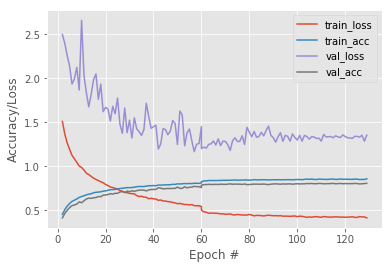

In [104]:
!cat train_5.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_5.csv
plot_train_log('train_5.csv')

### 修改LR schedule

In [114]:
def poly_decay(epoch):
    maxEpochs = 100
    baseLR = 0.01
    power = 2.0
    alpha = baseLR * (1 - (epoch/float(maxEpochs))) ** power
    return alpha

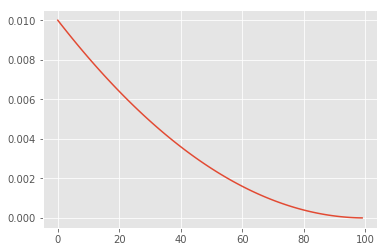

In [115]:
x = list(range(100))
y = [poly_decay(xx) for xx in x]
plt.plot(x,y)

In [23]:
len(train_iter)

390

In [ ]:
net.forward(x_test_gpus[0])

In [124]:
x_test_gpus[0].shape

(1, 3, 32, 32)

In [130]:
x_test.transpose((0,2,3,1)).shape

(2, 32, 32, 3)